In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt

In [ ]:
df= pd.read_csv("data/final_month_weather_T.csv",encoding="cp949")
df= df.drop(labels="Unnamed: 0", axis=1)

In [6]:
grouped= df.groupby(['행정구역', '일시']).mean()
grouped_fin= grouped
grouped_fin['면적']=0
grouped_fin['생산량']=0
grouped_fin['면적당 생산량']=0

In [7]:
#면적 -> 생산량
city_list= ['강원도', '경기도', '인천광역시', '서울특별시', '경상북도', '충청북도', '충청남도', '대전광역시','전라남도', '대구광역시', '전라북도', '울산광역시', '경상남도', '광주광역시', '부산광역시', '제주도','세종특별자치시']
detail = ["", ".1", ".2", ".3", ".4", ".5", ".6", ".7", ".8", ".9", ".10", ".11"]
spr= ['-03', '-04', '-05']
sum= ['-06', '-07', '-08']
fal= ['-09', '-10', '-11']
win= ['-01', '-02', '-12']
season_list= [spr, sum, fal, win]

for i in range(len(city_list)):
    for l in range(2000, 2022):
        for k in range(len(detail)):
            try:
                val= str(l) + detail[k]
                if (k%3) == 0:
                    for n in range(3):
                        dt= str(l) + season_list[int(k/3)][n]
                        grouped_fin.loc[(city_list[i], dt), '면적']= output_raw.loc[city_list[i], val]
                elif k==1 or k==4 or k==7 or k==10:
                    for n in range(3):
                        dt= str(l) + season_list[int(k/3)][n]
                        grouped_fin.loc[(city_list[i], dt), '면적당 생산량']= output_raw.loc[city_list[i], val]
                else:
                    for n in range(3):
                        dt= str(l) + season_list[int(k/3)][n]
                        grouped_fin.loc[(city_list[i], dt), '생산량']= output_raw.loc[city_list[i], val]
            except:
                pass

In [8]:
grouped_fin= grouped_fin[grouped_fin['면적당 생산량'] != 0]
grouped_fin= grouped_fin[grouped_fin['면적당 생산량'] != '-']
grouped_fin= grouped_fin[grouped_fin['면적당 생산량'] != '0']
grouped_fin= grouped_fin[grouped_fin['면적'] != 0]
grouped_fin= grouped_fin[grouped_fin['면적'] != '-']
grouped_fin= grouped_fin[grouped_fin['면적'] != '0']
grouped_fin= grouped_fin[grouped_fin['생산량'] != 0]
grouped_fin= grouped_fin[grouped_fin['생산량'] != '-']
grouped_fin= grouped_fin[grouped_fin['생산량'] != '0']
grouped_fin

평균기온(°C)   최고기온(°C)   최저기온(°C)  월합강수량(00~24h만)(mm)  \
행정구역 일시                                                             
강원도  2000-03   4.790909  19.000000  -7.936364           13.790909   
     2000-04  10.154545  23.518182  -1.872727           37.354545   
     2000-05  15.618182  31.500000   4.181818           75.181818   
     2000-06  20.600000  33.618182   9.190909          132.154545   
     2000-07  24.645455  34.027273  15.972727          156.536364   
...                 ...        ...        ...                 ...   
충청북도 2021-04  12.980000  28.580000   0.260000           62.020000   
     2021-05  16.040000  29.880000   3.220000          158.560000   
     2021-09  20.680000  29.100000  12.920000          191.580000   
     2021-10  13.760000  29.460000  -1.000000           35.260000   
     2021-11   6.800000  19.880000  -4.900000           47.800000   

              합계 일사량(MJ/m2)    면적     생산량 면적당 생산량  
행정구역 일시                                            
강원도  2000-03     433.992727  2147   87619    4081  
     2000-04     481.298636  2147   87619    4081  
     2000-05     518.235455  2147   87619    4081  
     2000-06     549.963182  7461  281280    3770  
     2000-07     516.617273  7461  281280    3770  
...                     ...   ...     ...     ...  
충청북도 2021-04     585.900000   686   30787    4491  
     2021-05     561.085000   686   30787    4491  
     2021-09     426.565000  2304  168678    7321  
     2021-10     407.200000  2304  168678    7321  
     2021-11     243.284000  2304  168678    7321  

[2424 rows x 8 columns]

In [9]:
tt= grouped_fin.reset_index()
train= tt[tt['일시'].str.contains('2021') == False]
test= tt[tt['일시'].str.contains('2021')]

In [12]:
feature= train[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)', '면적']]
target= train[['생산량']]

In [15]:
scaler1= MinMaxScaler()
scaler2= MinMaxScaler()

scaler1.fit(feature)
scaler2.fit(target)

feature_sc= scaler1.transform(feature)
target_sc= scaler2.transform(target)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(feature_sc, target_sc, test_size=0.2)

In [19]:
xgb = XGBRegressor()

alpha = np.logspace(-4,2,7)   # lasso, ridge 해당
max_iter = [1,3,5,10,20,50,100,150,200]   # lasso, ridge 해당
solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']   # ridge 해당, 계산에 사용할 알고리즘
eta = np.logspace(-3,2,6)   # xgboost 해당
n_estimators = [15,20,50,100,200,500]   # randomforesteregressor(사용할 tree의 개수), gradientboost, adaboost, xgboost 해당
max_depth = [2,3,5,7,10,12]  # randomforesteregressor(tree의 깊이), gradientboost, xgboost 해당
gamma = [0, 0.05, 0.1, 0.2, 0.5]    # xgboost 해당
max_leaf_nodes = [2,3,5,7]     # randomforest, xgboost 해당
min_child_weight = [1,2,3,5]   # xgboost 해당

params_xgb = {"learning_rate" : eta,
                "n_estimators" : n_estimators, 
                "max_depth" : max_depth, 
                "gamma" : gamma,
                "min_child_weight" : min_child_weight}

In [20]:
kfold = KFold(5, shuffle=True, random_state=6)

In [21]:
grid_xgb = GridSearchCV(estimator=xgb, param_grid=params_xgb, n_jobs=-1, cv=kfold, scoring="neg_mean_squared_error")
grid_xgb.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.1689658  -0.16734679 -0.15794637 ...         nan         nan
         nan]
  warnings.warn(


[03:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=6, shuffle=True),
             estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'gamma': [0, 0.05, 0.1, 0.2, 0.5],
                         'learning_rate': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'max_depth': [2, 3, 5, 7, 10, 12],
                         'min_child_weight': [1, 2, 3, 5],
                         'n_estimators': [15, 20, 50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

In [22]:
print("best score :", grid_xgb.best_score_)
print("best parameter :", grid_xgb.best_params_)

best score : -0.0014619511417048418
best parameter : {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 500}


In [23]:
em = grid_xgb.best_estimator_
y_pred_train = em.predict(X_train)
print("r2 score :", r2_score(y_train, y_pred_train))

r2 score : 0.9996964258329282


In [24]:
y_pred = em.predict(X_test)
print("r2 score :", r2_score(y_test, y_pred))

r2 score : 0.9698186928212627


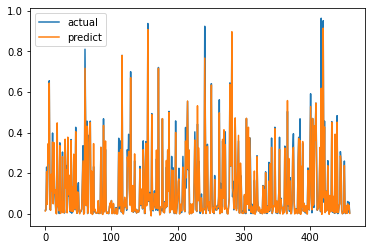

In [25]:

plt.plot(y_test.flatten(), label="actual")
plt.plot(y_pred.flatten(), label="predict")
plt.legend()
plt.show()

In [53]:
feature= test[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)', '면적']]
target= test[['생산량']]

In [55]:
feature_sc= scaler1.transform(feature)

In [59]:
test_data_sc= pd.DataFrame(feature_sc, columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5'])

y_pred = grid_xgb.predict(test_data_sc)

y_pred = y_pred.reshape(-1,1)

y_pred = scaler2.inverse_transform(y_pred)

y_pred

array([[ 5.11111328e+04],
       [ 4.61516484e+04],
       [ 4.82193750e+04],
       [ 1.94815547e+05],
       [ 2.07543625e+05],
       [ 1.93005250e+05],
       [ 1.38350734e+05],
       [ 1.43593266e+05],
       [ 1.34477031e+05],
       [ 1.55004648e+04],
       [ 1.57840615e+04],
       [ 1.55471602e+04],
       [ 1.28828945e+05],
       [ 1.26750320e+05],
       [ 1.15162602e+05],
       [ 1.03980283e+04],
       [ 8.02414258e+03],
       [ 7.63379102e+03],
       [ 9.07923340e+02],
       [-8.85840698e+02],
       [-1.94298096e+02],
       [ 3.48241953e+04],
       [ 3.19552285e+04],
       [ 3.54127461e+04],
       [ 6.73066953e+04],
       [ 6.49125469e+04],
       [ 6.34670898e+04],
       [ 1.91494121e+04],
       [ 1.40267080e+04],
       [ 1.79011250e+04],
       [ 1.79401688e+05],
       [ 1.74390078e+05],
       [ 1.82536062e+05],
       [ 4.90895410e+03],
       [ 1.61858472e+03],
       [ 5.92627502e+02],
       [ 6.53066309e+03],
       [ 4.74082568e+03],
       [ 3.2

In [28]:
y_pred_test = em.predict(feature_sc)
print("r2 score :", r2_score(target_sc, y_pred_test))

r2 score : 0.9519336969549884


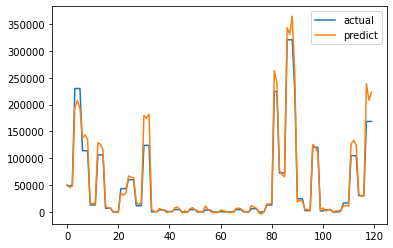

In [32]:
y_pred_actual= scaler2.inverse_transform(y_pred_test.reshape(-1,1))
target_actual= scaler2.inverse_transform(target_sc)

plt.plot(target_actual, label="actual")
plt.plot(y_pred_actual, label="predict")
plt.legend()
plt.show()

-7.049017622807879


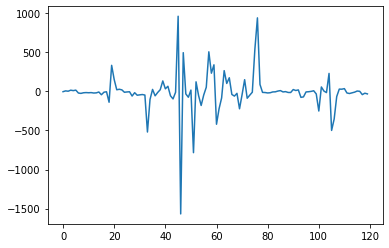

In [42]:
diff= ((target_actual - y_pred_actual)/target_actual) *100

print(diff.mean())
plt.plot(diff)

In [47]:
diff.argmax()
y_pred_actual[45]

array([-1326.0587], dtype=float32)

In [36]:
lstm_train= train.set_index(['행정구역', '일시'])
lstm_test= test.set_index(['행정구역', '일시'])

In [62]:
feature= lstm_train[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)', '면적']]
target= lstm_train[['생산량']]

mms1= MinMaxScaler()
mms2= MinMaxScaler()

mms1.fit(feature)
mms2.fit(target)

ft_sc= mms1.transform(feature)
tg_sc= mms2.transform(target)

In [75]:
window_size = 3

data_X = []
data_y = []
for i in range(0,len(tg_sc),3):
    _X = ft_sc[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = tg_sc[i + window_size - 1]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.72008589 0.67074242 0.65215913 0.19553095 0.51690197 0.21194789]
 [0.47413625 0.49208673 0.39563263 0.00869183 0.49922087 0.21194789]
 [0.29513957 0.39661081 0.27133628 0.03761751 0.26518515 0.21194789]] -> [0.31632043]


In [76]:
train_size = int(len(data_y) * 0.8)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (614, 3, 6) (614, 1)
테스트 데이터의 크기 : (154, 3, 6) (154, 1)


In [77]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', input_shape=(3, 6)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [78]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model.fit(train_X, train_y, epochs=70, batch_size=30, callbacks=[early_stop])

Epoch 1/70
21/21 [==============================] - 3s 8ms/step - loss: 0.0337
Epoch 2/70
21/21 [==============================] - 0s 7ms/step - loss: 0.0255
Epoch 3/70
21/21 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 4/70
21/21 [==============================] - 0s 7ms/step - loss: 0.0184
Epoch 5/70
21/21 [==============================] - 0s 8ms/step - loss: 0.0146
Epoch 6/70
21/21 [==============================] - 0s 7ms/step - loss: 0.0117
Epoch 7/70
21/21 [==============================] - 0s 8ms/step - loss: 0.0097
Epoch 8/70
21/21 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 9/70
21/21 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 10/70
21/21 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 11/70
21/21 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 12/70
21/21 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 13/70
21/21 [==============================

5/5 [==============================] - 0s 5ms/step


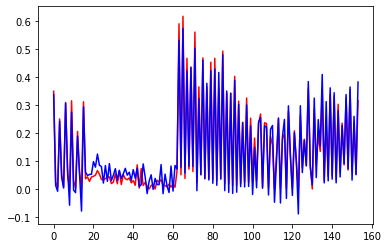

In [79]:
pred_y = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red')
plt.plot(pred_y, color='blue')
plt.show()

In [80]:
test_score= r2_score(test_y, pred_y)
print(test_score)

0.9547972252425435


In [81]:
feature= lstm_test[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)', '면적']]
target= lstm_test[['생산량']]

mms1.fit(feature)
mms2.fit(target)

ft_sc= mms1.transform(feature)
tg_sc= mms2.transform(target)

In [82]:
window_size = 3

data_X = []
data_y = []
for i in range(0,len(tg_sc),3):
    _X = ft_sc[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = tg_sc[i + window_size - 1]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.76998255 0.64433866 0.791597   0.38153787 0.49182302 0.44755789]
 [0.48819081 0.66147569 0.3738478  0.05897682 0.45166976 0.44755789]
 [0.20477022 0.20544033 0.256806   0.08485268 0.11179049 0.44755789]] -> [0.52614917]


In [84]:
test_X_1 = np.array(data_X)
test_y_1 = np.array(data_y)

print(test_X_1.shape, test_y_1.shape)

(40, 3, 6) (40, 1)


2/2 [==============================] - 0s 5ms/step


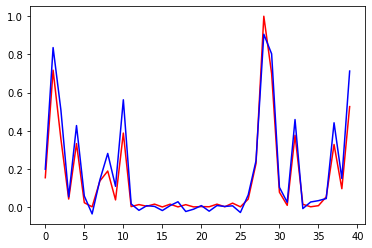

In [89]:
pred_y_fin = model.predict(test_X_1)

plt.figure()
plt.plot(test_y_1, color='red')
plt.plot(pred_y_fin, color='blue')
plt.show()

In [86]:
test_score= r2_score(test_y_1, pred_y_fin)
print(test_score)

0.9175267116664299


In [92]:
pred_y_fin= mms2.inverse_transform(pred_y_fin)

pred_y_fin

array([[ 63569.594 ],
       [267825.72  ],
       [162881.22  ],
       [ 17098.488 ],
       [136840.53  ],
       [ 18520.057 ],
       [-11533.3125],
       [ 45830.504 ],
       [ 90018.68  ],
       [ 34826.766 ],
       [180163.02  ],
       [  5278.1978],
       [ -5515.6646],
       [  2301.0984],
       [  1066.2372],
       [ -5868.5845],
       [  2435.8987],
       [  8891.124 ],
       [ -7465.4575],
       [ -3614.9414],
       [  2442.5425],
       [ -6950.286 ],
       [  2545.9333],
       [   977.1482],
       [  2071.0686],
       [ -9126.806 ],
       [ 20282.908 ],
       [ 77634.836 ],
       [290248.7   ],
       [257364.36  ],
       [ 33115.92  ],
       [  7976.3745],
       [146964.4   ],
       [ -2588.4773],
       [  8476.6875],
       [ 10739.382 ],
       [ 14288.355 ],
       [141519.45  ],
       [ 47912.832 ],
       [228392.17  ]], dtype=float32)

In [93]:
test_y_1= mms2.inverse_transform(test_y_1)

test_y_1

array([[4.92580e+04],
       [2.29873e+05],
       [1.14251e+05],
       [1.34340e+04],
       [1.06510e+05],
       [7.27300e+03],
       [3.80000e+02],
       [4.38450e+04],
       [6.04770e+04],
       [1.19970e+04],
       [1.24232e+05],
       [7.92000e+02],
       [4.16200e+03],
       [1.34300e+03],
       [4.89500e+03],
       [1.54000e+02],
       [4.82100e+03],
       [2.59000e+02],
       [4.01700e+03],
       [2.28000e+02],
       [7.71000e+02],
       [4.87000e+02],
       [4.83900e+03],
       [5.03000e+02],
       [6.57700e+03],
       [3.78000e+02],
       [1.33330e+04],
       [7.29930e+04],
       [3.20451e+05],
       [2.24283e+05],
       [2.49010e+04],
       [2.86800e+03],
       [1.20590e+05],
       [4.65600e+03],
       [4.34000e+02],
       [2.30100e+03],
       [1.71110e+04],
       [1.05059e+05],
       [3.07870e+04],
       [1.68678e+05]])